# Load the trained conditional diffusion model and perform generation

In [58]:
import torch
import torchvision

In [59]:
print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available()) 
print(torch.cuda.device_count()) 
print(torch.cuda.current_device()) 

2.1.0
0.16.0
True
1
0


In [60]:
# Specify the variable contained in the filename of the model to be loaded
now = '150307'
lr_ddpm = 1e-4
model_epoch = 299

## Importing modules

In [61]:
import numpy as np
import os
import random
import glob
import argparse, logging, copy
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from tqdm import tqdm
from IPython.display import clear_output
from pathlib import Path
from PIL import Image
from types import SimpleNamespace
from contextlib import nullcontext
from fastprogress import progress_bar
from modules import UNet_conditional, EMA
from datetime import datetime

import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision import transforms
from torchvision.utils import save_image

In [62]:
batch_size = 15 

## train_dataset/train_dataloader

In [63]:
class MyTransform():
    def __init__(self, isNormalize=True):
        if isNormalize:
            self.my_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, ), (0.5, ))
            ])
        else:
            self.my_transform = transforms.Compose([
                transforms.ToTensor()
            ])
    def __call__(self, img):
        return self.my_transform(img)

In [64]:
class NpyDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, label_file, transform=None):
        self.data = np.load(data_file)
        self.label = np.load(label_file, allow_pickle=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.label[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

In [67]:
train_dir = "saved_datasets/train"

train_data = np.load(os.path.join(train_dir, "train_dataset_data.npy"))
train_label = np.load(os.path.join(train_dir, "train_dataset_label.npy"))

train_dataloader_settings = np.load(
    os.path.join(train_dir, "dataloader_settings.npy"),
    allow_pickle=True
).item()

data_tra = NpyDataset(
    data_file=os.path.join(train_dir, "train_dataset_data.npy"),
    label_file=os.path.join(train_dir, "train_dataset_label.npy"),
    transform=MyTransform(isNormalize=False)
)

print("train_dataset", len(data_tra))

g = torch.Generator()
g.manual_seed(42)

train_dataloader = torch.utils.data.DataLoader(
    data_tra,
    **train_dataloader_settings,
    generator=g
)
print("train_dataloader", len(train_dataloader))

train_dataset 72
train_dataloader 4


In [68]:
print(train_data.shape)

(72, 64, 64, 2)


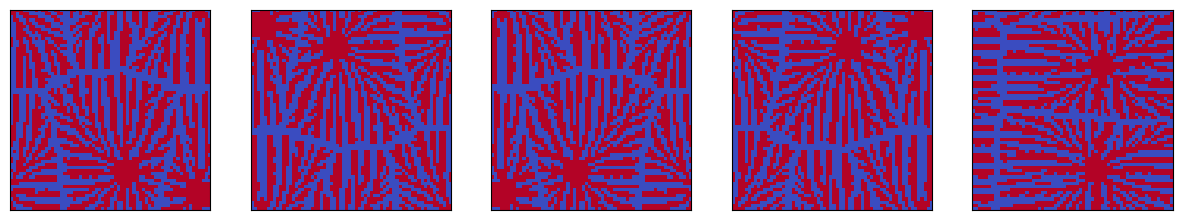

In [69]:
# When seeing the dataset --> Since it hasn't been shuffled, it's in order

plt.figure(figsize=(15,6))

for i in range(5):
    img, labels_list = data_tra[i]
    img = img[0]
    plt.subplot(1,5,i+1) 
    plt.imshow(img, cmap="coolwarm",interpolation='none')
    plt.tick_params(labelbottom=False,labelleft=False)
    plt.tick_params(bottom=False,left=False)

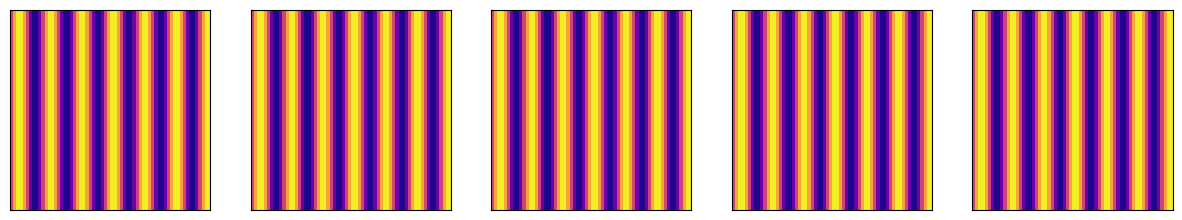

In [70]:
plt.figure(figsize=(15,6))

for i in range(5):
    img, labels_list = data_tra[i]
    img2 = img[1]
    plt.subplot(1,5, i+1)
    plt.imshow(img2, cmap="plasma",norm=Normalize(vmin=-1,vmax=1))
    plt.tick_params(labelbottom=False,labelleft=False)
    plt.tick_params(bottom=False,left=False)

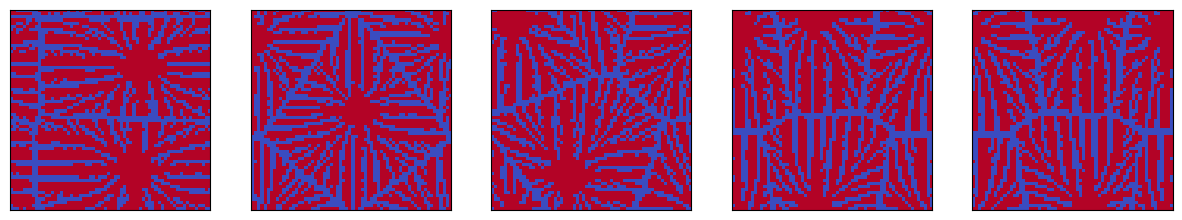

In [71]:
plt.figure(figsize=(15,6))

for i in range(5):
    plt.subplot(1,5,i+1)
    batch = next(iter(train_dataloader))
    img = batch[0][i][0]
    plt.imshow(img, cmap="coolwarm",interpolation='none')
    plt.tick_params(labelbottom=False,labelleft=False)
    plt.tick_params(bottom=False,left=False)  

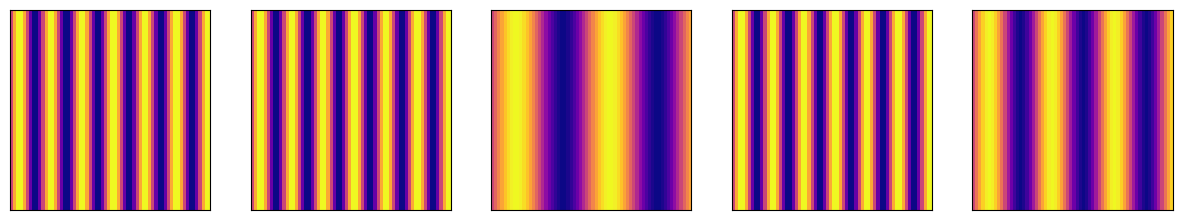

In [72]:
plt.figure(figsize=(15,6))

for i in range(5):
    plt.subplot(1,5,i+1)
    batch = next(iter(train_dataloader))
    img = batch[0][i][1]
    plt.imshow(img, cmap="plasma",interpolation='none')
    plt.tick_params(labelbottom=False,labelleft=False)
    plt.tick_params(bottom=False,left=False)  

## validation_dataset/validation_dataloader

In [12]:
class MyTransform():
    def __init__(self, isNormalize=True):
        if isNormalize:
            self.my_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, ), (0.5, ))  
            ])
        else:
            self.my_transform = transforms.Compose([
                transforms.ToTensor()
            ])
    def __call__(self, img):
        return self.my_transform(img)

In [13]:
class NpyDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, label_file, transform=None):
        self.data = np.load(data_file)
        self.label = np.load(label_file, allow_pickle=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.label[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

In [73]:
val_dir = "saved_datasets/val"

val_data = np.load(os.path.join(val_dir, "val_dataset_data.npy"))
val_label = np.load(os.path.join(val_dir, "val_dataset_label.npy"))

val_dataloader_settings = np.load(
    os.path.join(val_dir, "val_dataloader_settings.npy"),
    allow_pickle=True
).item()

data_val = NpyDataset(
    data_file=os.path.join(val_dir, "val_dataset_data.npy"),
    label_file=os.path.join(val_dir, "val_dataset_label.npy"),
    transform=MyTransform(isNormalize=False)
)

print("val_dataset", len(data_val))

val_dataloader = torch.utils.data.DataLoader(
    data_val,
    **val_dataloader_settings
)
print("val_dataloader", len(val_dataloader))

val_dataset 24
val_dataloader 2


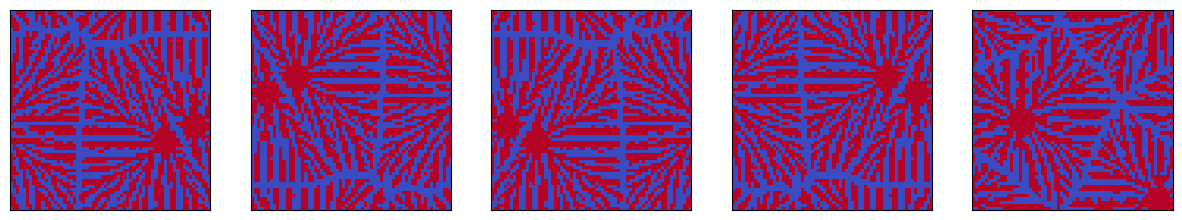

In [74]:
# When seeing the dataset --> Since it hasn't been shuffled, it's in order

plt.figure(figsize=(15,6))

for i in range(5):
    img, labels_list = data_val[i]
    img = img[0]
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap="coolwarm",interpolation='none')
    plt.tick_params(labelbottom=False,labelleft=False)
    plt.tick_params(bottom=False,left=False)

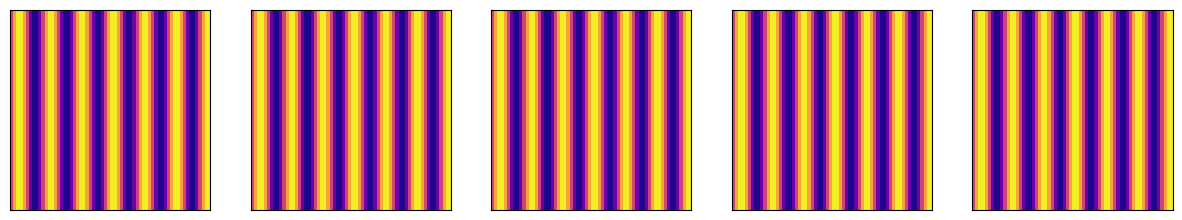

In [75]:
plt.figure(figsize=(15,6))

for i in range(5):
    img, labels_list = data_val[i]
    img2 = img[1]
    plt.subplot(1,5,i+1)
    plt.imshow(img2, cmap="plasma",norm=Normalize(vmin=-1,vmax=1))
    plt.tick_params(labelbottom=False,labelleft=False)
    plt.tick_params(bottom=False,left=False)

In [76]:
gpu = torch.device("cuda")
cpu = torch.device("cpu")
print(gpu)

cuda


## ddpm_conditional

In [19]:
epochs_ddpm = 10000
config = SimpleNamespace(    
    run_name = "DDPM_conditional",
    epochs = epochs_ddpm,
    noise_steps=1000,
    seed = 42,
    batch_size = batch_size,
    img_size = 64,
    device = "cuda",
    slice_size = 1,
    do_validation = True,
    fp16 = True,
    log_every_epoch = 1000,
    num_workers=4,
    lr = lr_ddpm)

In [20]:
config

namespace(run_name='DDPM_conditional',
          epochs=10000,
          noise_steps=1000,
          seed=42,
          batch_size=15,
          img_size=64,
          device='cuda',
          slice_size=1,
          do_validation=True,
          fp16=True,
          log_every_epoch=1000,
          num_workers=4,
          lr=0.0001)

In [21]:
def set_seed(s, reproducible=False):
    try: torch.manual_seed(s)
    except NameError: pass
    try: torch.cuda.manual_seed_all(s)
    except NameError: pass
    try: np.random.seed(s%(2**32-1))
    except NameError: pass
    random.seed(s)
    if reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [22]:
model_save_dir = os.path.join("./models", "models_{0}_{1}".format(now, lr_ddpm))

In [23]:
save_epoch = 10

class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, c_in=2, c_out=2,  device="cuda", **kwargs): 
        self.noise_steps = noise_steps 
        self.beta_start = beta_start
        self.beta_end = beta_end
        
        self.now = now
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.model = torch.load("./models/"+"models_{0}_{1}/".format(str(now),str(lr_ddpm))+"model_{0}.pt".format(model_epoch))
        self.ema_model = copy.deepcopy(self.model).eval().requires_grad_(False)
        self.device = device
        self.c_in = c_in

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
    
    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ
    
    @torch.inference_mode()
    def sample(self, use_ema, labels, cfg_scale=3): 
        model = self.ema_model if use_ema else self.model
        n = len(labels)
        model.eval()
        with torch.inference_mode():
            x = torch.randn((n, self.c_in, self.img_size, self.img_size)).to(self.device) 
            for i in progress_bar(reversed(range(1, self.noise_steps)), total=self.noise_steps-1, leave=False):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        return x

    def train_step(self, loss):
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        self.ema.step_ema(self.ema_model, self.model)
        self.scheduler.step()

    def one_epoch(self, train=True): 
        avg_loss = 0.
        if train: 
            self.model.train()
            pbar = progress_bar(train_dataloader, leave=False)
        
        else: 
            self.model.eval()
            pbar = progress_bar(val_dataloader, leave=False)
        for i, (images, labels) in enumerate(pbar):
            with torch.autocast("cuda") and (torch.inference_mode() if not train else torch.enable_grad()):
                images = images.to(self.device).float()
                labels = labels.to(self.device)
                t = self.sample_timesteps(images.shape[0]).to(self.device)
                x_t, noise = self.noise_images(images, t)

                if np.random.random() < 0.1:
                    labels = None
                predicted_noise = self.model(x_t, t, labels)
                loss = self.mse(noise, predicted_noise)
                avg_loss += loss
            if train:
                self.train_step(loss)
            pbar.comment = f"MSE={loss.item():2.3f}"   
        return avg_loss.mean()
    
    def load(self, model_cpkt_path, model_ckpt="ckpt.pt", ema_model_ckpt="ema_ckpt.pt"):
        self.model.load_state_dict(torch.load(os.path.join(model_cpkt_path, model_ckpt)))
        self.ema_model.load_state_dict(torch.load(os.path.join(model_cpkt_path, ema_model_ckpt)))
     
    def save_model(self, run_name, epoch=-1): 
        torch.save(self.model.state_dict(), os.path.join(model_save_dir, "ckpt.pt"))
        torch.save(self.ema_model.state_dict(), os.path.join(model_save_dir, "ema_ckpt.pt"))
        torch.save(self.optimizer.state_dict(), os.path.join(model_save_dir, "optim.pt"))

    def prepare(self, args):
        self.optimizer = optim.AdamW(self.model.parameters(), lr=args.lr, eps=1e-5)
        self.scheduler = optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=args.lr, 
                                                 steps_per_epoch=len(train_dataloader), epochs=args.epochs)
        self.mse = nn.MSELoss()
        self.ema = EMA(0.995)
        self.scaler = torch.cuda.amp.GradScaler()
        
        print(train_dataloader)
        print(val_dataloader)
  
    def fit(self, args):
        loss_li_tra = []
        loss_li_val = []
        date = "" 
        
        for epoch in progress_bar(range(args.epochs), total=args.epochs, leave=True):
            avg_loss_tra = self.one_epoch(train=True)
            loss_cpu_tra = avg_loss_tra.detach().to(cpu).numpy().copy()
            # training loss
            if epoch % 1000 == 0: 
                print("tra_loss", avg_loss_tra.item())
            loss_li_tra.append( loss_cpu_tra  )
            if epoch % 1000==0 :
                fig = plt.figure(figsize=(16,6))
                gs = fig.add_gridspec(2,5)
                ax4curve = fig.add_subplot(gs[0:2,0:2])
                loss_li_tra.append( loss_cpu_tra  )
                plt.plot( loss_li_tra )
                plt.yscale("log")
                plt.title('train_loss,'+"epoch:"+str(epoch))                  

            if args.do_validation:
                avg_loss = self.one_epoch(train=False)
                loss_cpu_val = avg_loss.detach().to(cpu).numpy().copy()
            # validation loss
            if epoch % 1000 == 0: 
                print("val_loss", avg_loss.item())
                logging.info(f"Starting epoch {epoch}:")
                loss_li_val.append( loss_cpu_val  )
            if epoch % 1000 == 0 :
                fig = plt.figure(figsize=(16,6))
                gs = fig.add_gridspec(2,5)
                ax4curve = fig.add_subplot(gs[0:2,0:2])
                loss_li_val.append( loss_cpu_val  )
                plt.plot( loss_li_val )
                plt.yscale("log")
                plt.title('validation_loss,'+"epoch:"+str(epoch))                  
        
            if epoch % save_epoch == save_epoch-1:
                if epoch < save_epoch:
                    self.save_model(run_name=args.run_name, epoch=epoch)
                torch.save(self.model, os.path.join(model_save_dir, "model_{0}.pt".format(epoch)))                

            if epoch % save_epoch == save_epoch-1:
                fig = plt.figure(figsize=(16,6))
                gs = fig.add_gridspec(2,5)
                ax4curve = fig.add_subplot(gs[0:2,0:2])
                loss_li_tra.append( loss_cpu_tra  )
                plt.plot( loss_li_tra )
                plt.yscale("log")
                plt.title('train_loss,'+"epoch:"+str(epoch))
                plt.savefig(os.path.join(model_save_dir, 'tra_loss{0}.png'.format(epoch)))
                
                fig = plt.figure(figsize=(16,6))
                gs = fig.add_gridspec(2,5)
                ax4curve = fig.add_subplot(gs[0:2,0:2])
                loss_li_val.append( loss_cpu_val  )
                plt.plot( loss_li_val )
                plt.yscale("log")
                plt.title('validation_loss,'+"epoch:"+str(epoch))  
                plt.savefig(os.path.join(model_save_dir, 'val_loss{0}.png'.format(epoch)))

In [24]:
def parse_args(config):
    
    import easydict
    args = easydict.EasyDict({
        "run_name": config.run_name,
        "epoch": config.epochs,
        "seed": config.seed,
        "batch_size": config.batch_size,
        "img_size": config.img_size,
        "device": config.device,
        "lr": config.lr,
        "slice_size": config.slice_size,
        "noise_steps": config.noise_steps
    })
    
    for k, v in args.items():
        setattr(config, k, v)

In [25]:
diffuser = Diffusion(config.noise_steps, img_size=config.img_size)

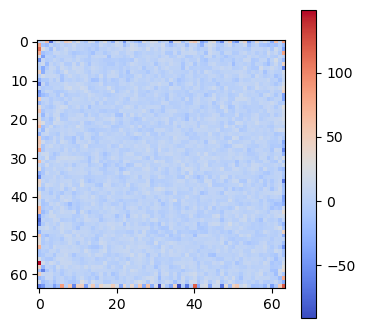

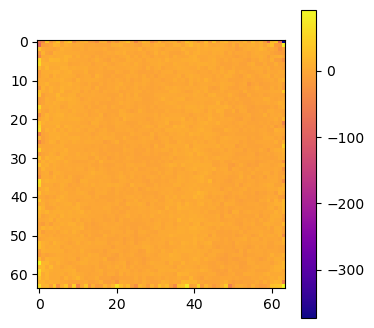

In [26]:
labels = torch.tensor([[0.5,0.2,0.4]]).cuda() 

samples0 = diffuser.sample(use_ema=True, labels=labels)
samples = samples0.cpu()[0,:,:,:]
samples_num = samples.numpy()
plt.figure(figsize=(4, 4))
plt.imshow(samples0.cpu()[0,0,:,:],cmap='coolwarm',interpolation='none') 
plt.colorbar()
plt.show()
plt.figure(figsize=(4, 4))
plt.imshow(samples0.cpu()[0,1,:,:],cmap='plasma',interpolation='none') 
plt.colorbar()
plt.show()